In [3]:
# installing necessary dependencies
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import seaborn
import plotly.express as px
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# read datafile
data = pd.read_csv("PAPER3_DATA_v1.0.csv", quoting=csv.QUOTE_NONE)

data.columns = ['num', 'ISIN', 'date', 'price', 'ID_RR', 'isBND', 'incident_count', 'unsharp', 'severity', 'reach', 'novelty', 'environmental', 'social', 'governance']

for key in ['num', 'ISIN']:
    data[key] = data[key].str.replace('\"', '')

data = data.dropna()

data['date'] = pd.to_datetime(data['date'])

# calculate incident scores
# severity_weights = {1: 1, 
#                     2: 10, 
#                     3: 100}
reach_weights = {1: 1, 
                  2: 2, 
                  3: 3}
# novelty_weights = {1: 1,
#                    2: 2}

data['score'] = np.where(data['incident_count'] != 0, 
                         10**((data['severity'] / data['incident_count']) - 1) * (data['reach'] / data['incident_count']) * (data['novelty'] / data['incident_count']),
                         0)
# data["score"] = (data['severity'].replace(severity_weights)
#                                    *data['reach'].replace(reach_weights)
#                                    *data['novelty'].replace(novelty_weights))

# calculate time weights
n_years = 2
n_days = 365*n_years
curvature_ = 1
weights = np.arange(1,n_days + 1)
weights = weights/weights.max()
weights = ((2**weights) - 1)**curvature_
time_weights = pd.Series(weights)

def get_raw_scores(id_, data, col='score'):
    try:
        incidents = data[data['ISIN'] == id_]
        incidents.set_index('date', inplace=True)
        incident_scores = incidents[col]
        score = incident_scores.rolling(n_days).apply(lambda scores: np.dot(scores, time_weights)).fillna(0)
        return score
    except Exception as e:
        print("error occured", e)

def scale(series, lambda_=0.000105, curvature=5.3):
    return 100*((1 - np.exp(-lambda_*series))**(1/curvature))

scaling = scale(pd.Series(range(750)))

def max_decay(series, decay=0.5**(1/365)):
    new_series = pd.Series(index=series.index, dtype="float")
    previous = 0
    for date, value in series.items():
        if previous > 0:
            if value/previous < decay:
                new_series[date] = previous*decay
            else:
                new_series[date] = value
        else:
            new_series[date] = value
            
        previous = new_series[date]
    return new_series

C:\Users\anish\AppData\Local\Temp\ipykernel_30836\785480264.py:13: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("PAPER3_DATA_v1.0.csv", quoting=csv.QUOTE_NONE)


In [11]:
ISIN = 'DE0007664039' # Tesla

scores = data[data['ISIN'] == ISIN]

esg_metrics = {'ISIN': scores['ISIN'].values, 'date': scores['date'].values, 'price': scores['price'].values}

esgx = ['environmental', 'social', 'governance']
for subscore in esgx:
    scores[subscore + '_score'] = np.where(scores['incident_count'] != 0, scores['score']*scores[subscore]/scores['incident_count'], 0)
    esg_metrics[subscore] = max_decay(scale(get_raw_scores(ISIN, scores, subscore + '_score'))).values
esg_metrics['esg_score'] = max_decay(scale(get_raw_scores(ISIN, data, 'score')))

scores = pd.DataFrame(esg_metrics)
scores.set_index('date', inplace=True)
print(scores.tail(5))

C:\Users\anish\AppData\Local\Temp\ipykernel_30836\2309410916.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anish\AppData\Local\Temp\ipykernel_30836\2309410916.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anish\AppData\Local\Temp\ipykernel_30836\2309410916.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

                    ISIN   price  environmental     social  governance  \
date                                                                     
2022-05-16  DE0007664039  144.74      63.618089  55.154492   65.026538   
2022-05-17  DE0007664039  145.92      63.586763  55.125330   64.992282   
2022-05-18  DE0007664039  145.98      63.555392  55.578789   64.957970   
2022-05-19  DE0007664039  145.32      63.523977  55.549779   64.935004   
2022-05-20  DE0007664039  145.68      63.612568  55.520727   64.954680   

            esg_score  
date                   
2022-05-16  68.540518  
2022-05-17  68.505477  
2022-05-18  68.644081  
2022-05-19  68.617697  
2022-05-20  68.664600  


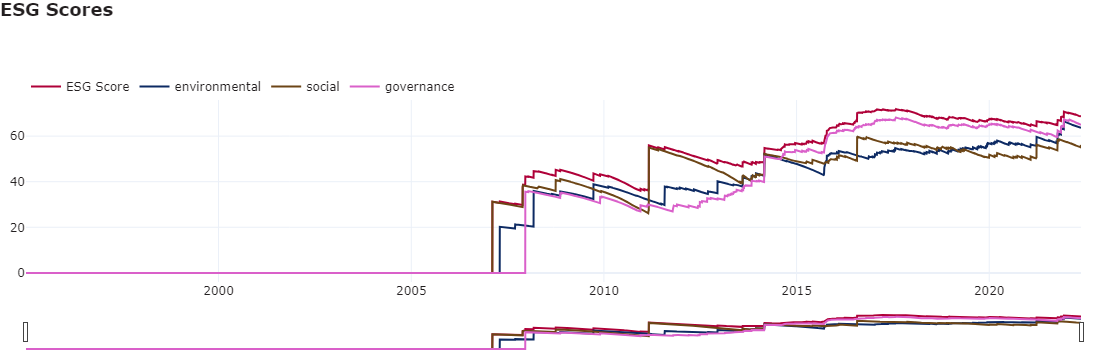

In [12]:
colors = px.colors.qualitative.Dark24*2
fig = go.Figure()
fig.add_trace(go.Scatter(x=scores['esg_score'].index, y=scores['esg_score'].values, name='ESG Score',
                  line=dict(color=colors.pop())))
for subscore in esgx:
    fig.add_trace(go.Scatter(x=scores[subscore].index, y=scores[subscore].values, name=subscore,
                  line=dict(color=colors.pop())))
fig.update_traces(hovertemplate='ESG score: %{y}')
fig.update_yaxes(tickfont=dict(color='#231F20'))
fig.update_xaxes(tickfont=dict(color='#231F20'))
fig.update_layout(font=dict(color='#231F20', family='UnitWeb, UnitOT, Verdana'),
                  xaxis_rangeslider_visible=True,
                  legend=dict(title=dict(text=" ", side='top'), x=0, y=0.99, 
                              orientation="h", bgcolor='rgba(0,0,0,0)'),
                  legend_font_color="#231F20",
                  template="plotly_white",
                  margin=dict(l=20, r=20, b=10),
                  autosize=True,
                  title=dict(text='<b>ESG Scores</b>',
                             y=0.99, x=0,
                             xanchor='left',
                             yanchor='top'),
                  title_font_family="UnitWeb, UnitOT, Verdana",
                  title_font_color="#231F20",
                  title_font_size=18)
fig.show()